In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime

dataset_path = '../data/raw/export_df.parquet'

ČLANAK https://arxiv.org/pdf/2004.00433.pdf

# Predprocesuiranje podataka

In [4]:
data = pd.read_parquet(dataset_path)
data.head()


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


#### Uklanjanje zapisa (redaka) gdje je zemlja gosta 0 

In [5]:
data = data[~(data['zemlja_gosta']=='0')]

#### Uklanjanje radaka s otkazanim rezervacijama

Zasada se fokusiramo na otklanjanjem outliera kod pojedinih hotela i to za ostvarene dolaske, moguće je proširiti na anomalije
 i kod otkazivanja, što bi ukazivalo da je neočekivana potražnja za hotelom te bi se možda moglo tumačiti zbog čega je došlo do toga, ali isto je tako korisno i ako vidimo da je veći broj otkazivanja kod cijenovnih anomalija
 

In [6]:
data = data[~data['datum_otkazivanja_rezervacije'].notna()]
data = data.reset_index(drop=True)
data.head(5)

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


#### Dodavanje stupca duljina_boravka

In [7]:
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days
data.head(10)


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,duljina_boravka
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152,0
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906,0
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2
5,0,2015-07-01,2015-04-21,2015-07-03,None,2,0.0,GBR,2,1,143.304560,Check-Out,1313228,1044263,2
6,0,2015-07-01,2015-06-25,2015-07-03,None,2,0.0,PRT,0,0,161.502814,Check-Out,1313229,1022260,2
7,0,2015-07-01,2014-09-15,2015-07-03,None,2,0.0,PRT,0,0,151.176542,Check-Out,1313230,1101557,2
8,0,2015-07-01,2014-10-14,2015-07-05,None,2,0.0,PRT,2,2,215.197422,Check-Out,1313234,1094841,4
9,0,2015-07-01,2015-03-16,2015-07-05,None,2,0.0,USA,2,2,63.461672,Check-Out,1313235,1025429,4


#### Dodavanje stupca  ukupno_gostiju ; broj djece za svaki redak (djeca + odrasli)

In [8]:
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']

##### Uklanjanje rezervacija u kojima nema gostiju, odnosno ukupan je broj gostiju 0

NOTE: Zašto ove retke uklanjamo sada, a ne nakon primjene statističke ili metode strojnog učenja? Jer ovdje govorimo o retcima u kojima je broj gpstiju nula, što znači kako su ti podaci nevaljani: označen je dolazak gosta, odnosno očekujemo da je gost došao, ali je zbog nekog razloga krivo postavljen broj gostiju te možemo reći da su ovdje krivo uneseni podaci

In [9]:
data = data[data['ukupno_gostiju'] != 0]

#### Dodavanje stupca raspon_dolazak_rezervacija

In [10]:
data['raspon_dolazak_rezervacija'] = (data['datum_dolaska'] - data['datum_kreiranja_rezervacije']).dt.days

####  Uklanjanje stupaca: 
   - datum otkazivanja rezervacije (ovdej imamo samo neotkazane rezervacije)
   - datum odjave : jer je autokoreliran s stupcima datum dolaska i duljina boravka
   - broj_odraslih_gostiju	te broj_djece_gostiju uklanjamo kako smo dodali stupac ukupan broj gostiju
   - status rezervacije (sve su vrijednosti iste iste - 'Check-Out')
   - rezervacija_id - od 74553 zapisa imamo i 74553 unikatne vrijednosti identifikatora
    (NE ODBACUJEMO gost_id jer od 74553 zapisaimamo 69764 gosta, što znači da imamo ponavljajućih gostiju)
   - datun_kreiranja_rezervacije - dodan je stupac raspon_dolazak_rezervacija koji označava razliku dana dolaska i kreiranja rezervacije 
   

In [11]:
data = data.drop(columns = ['datum_otkazivanja_rezervacije','datum_odjave','broj_odraslih_gostiju','broj_djece_gostiju','status_rezervacije','rezervacija_id','datum_kreiranja_rezervacije'],axis=1)
data.head()

,hotel_id,datum_dolaska,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,gost_id,duljina_boravka,ukupno_gostiju,raspon_dolazak_rezervacija
0,0,2015-07-01,PRT,0,0,100.000000,1077152,0,2.0,161
1,0,2015-07-01,PRT,0,0,100.000000,1017906,0,2.0,21
2,0,2015-07-01,GBR,0,1,64.991345,1039896,1,1.0,49
3,0,2015-07-01,GBR,1,1,74.368897,1008245,1,1.0,397
4,0,2015-07-01,GBR,2,1,130.973278,1093703,2,2.0,360


In [12]:
# data['datum_dolaska'] = pd.to_datetime(data['datum_dolaska'], errors='coerce')
# data.set_index('datum_dolaska', inplace=True)

In [13]:
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

- Na kojeme vremenskom okviru gledati outliere? 
- Kako pohraniti podatke na tjednoj razini u neku smislenu cjelinu?
    (agregacija na tjednoj razini u neku smislenu cjelinu, pogotovo s kategoričkim varijablama)

# Tjedna razina (promatramo tjednu fluktuaciju broja gostiju) za oba hotela

In [14]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('W').sum().to_frame()
NumberOfGuestsWeeklyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-04,35.0
2015-01-11,42.0
2015-01-18,54.0
2015-01-25,48.0
2015-02-01,27.0


In [15]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('W').sum().to_frame()
# NumberOfGuestsMonthlyResort.head(5)

## Naivan pristup : interkvartalni rang

 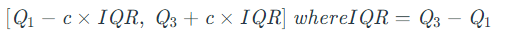

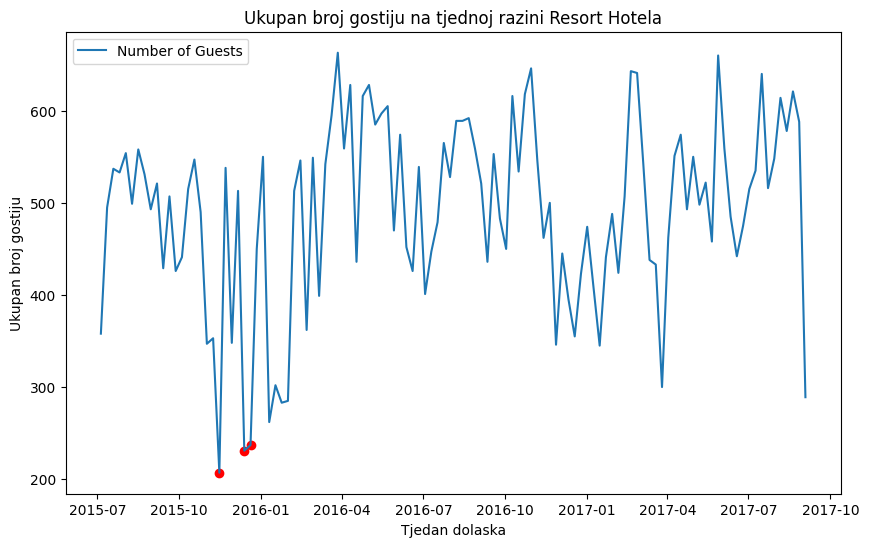

In [16]:
q11 = np.percentile(NumberOfGuestsWeeklyResort['ukupno_gostiju'], 25)
q31 = np.percentile(NumberOfGuestsWeeklyResort['ukupno_gostiju'],75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((NumberOfGuestsWeeklyResort['ukupno_gostiju'] < q11 - threshold1) | (NumberOfGuestsWeeklyResort['ukupno_gostiju'] > q31 + threshold1))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers1[0]:
    plt.scatter(NumberOfGuestsWeeklyResort.index[outlier], NumberOfGuestsWeeklyResort['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini Resort Hotela')
plt.legend()
plt.show()


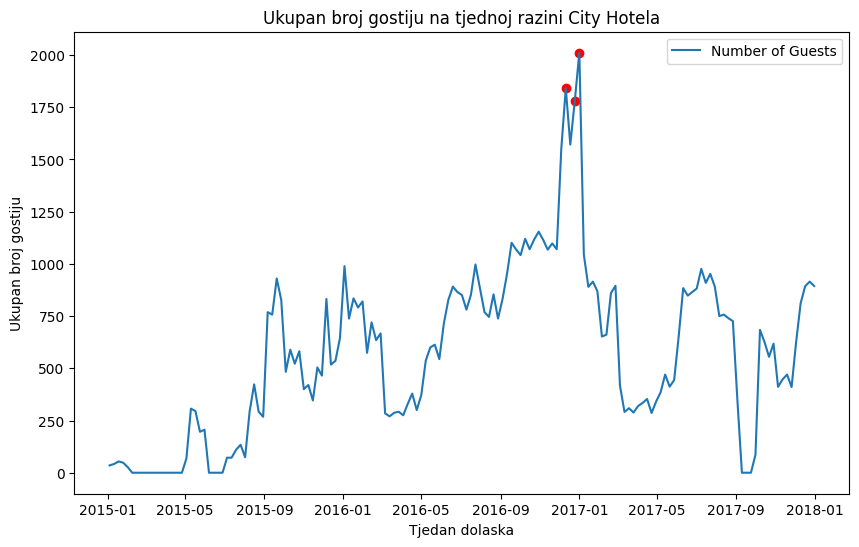

In [17]:
q12 = np.percentile(NumberOfGuestsWeeklyCity['ukupno_gostiju'], 25)
q32 = np.percentile(NumberOfGuestsWeeklyCity['ukupno_gostiju'],75)
iqr2 = q32 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((NumberOfGuestsWeeklyCity['ukupno_gostiju'] < q12 - threshold2) | (NumberOfGuestsWeeklyCity['ukupno_gostiju'] > q32 + threshold2))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers2[0]:
    plt.scatter(NumberOfGuestsWeeklyCity.index[outlier], NumberOfGuestsWeeklyCity['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()


#### ADTK OutlierDetector

" performs multivariate time-independent outlier detection and identifies outliers as anomalies. The multivariate outlier detection algorithm could be those in scikit-learn or other packages following same API."

In [18]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

In [19]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_resort = outlier_detector.fit_detect(NumberOfGuestsWeeklyResort)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False  True False False False  True
  True False False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]' has dtype incompatible with fl

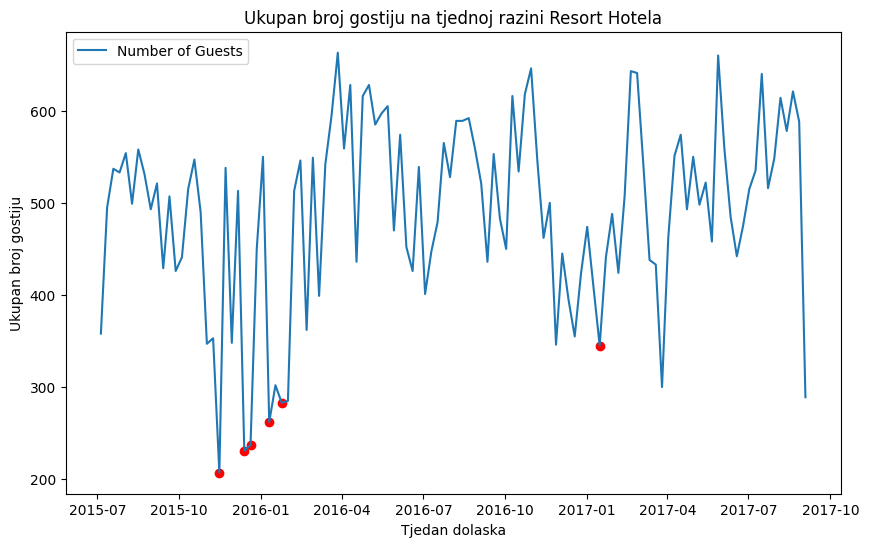

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_resort[anomalies_resort].index:
    if anomaly_date in NumberOfGuestsWeeklyResort.index:
        plt.scatter(anomaly_date, NumberOfGuestsWeeklyResort.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini Resort Hotela')
plt.legend()
plt.show()

In [21]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_city = outlier_detector.fit_detect(NumberOfGuestsWeeklyCity)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False  True  True  True  True  True False False False
 False False False False False False False False False False False Fa

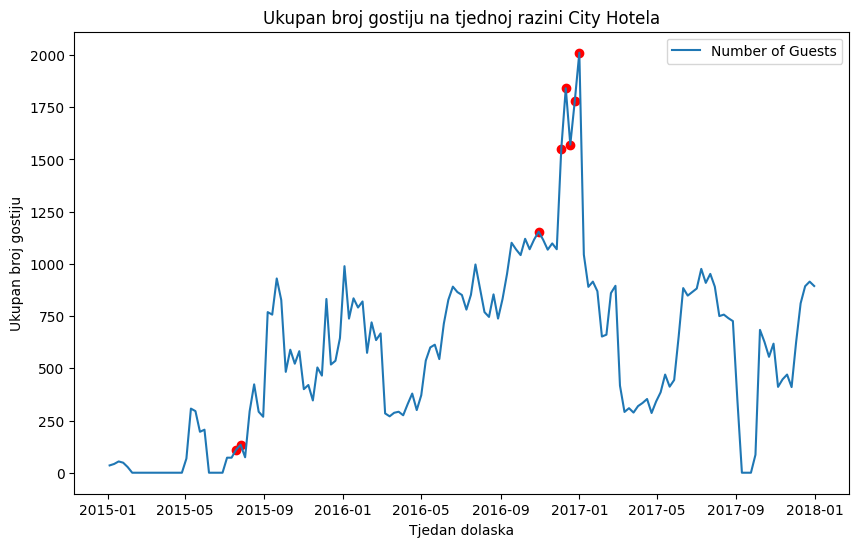

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_city[anomalies_city].index:
    if anomaly_date in NumberOfGuestsWeeklyCity.index:
        plt.scatter(anomaly_date, NumberOfGuestsWeeklyCity.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()

## (Unsupervised) Isolation Forests na univarijatnim podacima 

A sliding window is a common technique for analyzing time series data. It involves dividing the data into overlapping or non-overlapping chunks, or “windows,” and analyzing each window separately. This can be useful for identifying patterns or trends that may not be apparent when analyzing the entire dataset.

To use a sliding window with the isolation forest algorithm for anomaly detection, you can concatenate the data of each window and apply the algorithm to the resulting data matrix.

they do not require any feature engineering (such as normalizing, resampling and scaling)

 Isolation Score for the Isolation Forest


 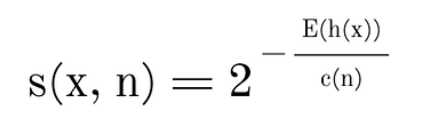

- h(x) - This is the average search height for 'x' from the isolation trees constructed 
- c(n) is the average search height (or depth) to find any general node in your isolation trees
- n is the number of external nodes in the Binary Search Tree (sample size)
- Note: External nodes are leaf nodes that could not be split further and reside at the bottom of the tree. 

In [23]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

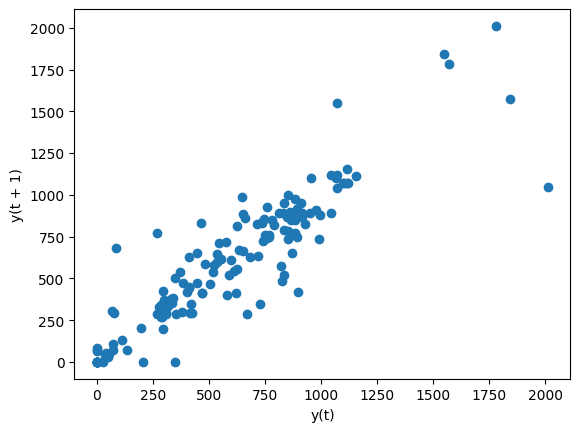

In [24]:
pd.plotting.lag_plot(NumberOfGuestsWeeklyCity, lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

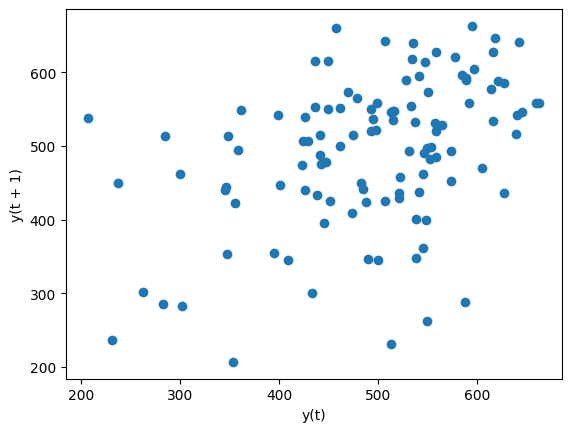

In [25]:
pd.plotting.lag_plot(NumberOfGuestsWeeklyResort, lag=1)

In [29]:
outliers_fraction = float(0.05)

In [30]:
if_model_city = IsolationForest(random_state = 0, 
                                contamination = outliers_fraction,
                                bootstrap=False,
                                verbose=True
                                )

In [63]:
city_data = NumberOfGuestsWeeklyCity['ukupno_gostiju'].values.reshape(-1,1)

In [65]:
scaler = StandardScaler()
city_data_stand = scaler.fit_transform(city_data)

In [66]:
if_model_city.fit(city_data_stand)

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [67]:
NumberOfGuestsWeeklyCity['score'] = if_model_city.decision_function(city_data_stand)
NumberOfGuestsWeeklyCity['anomaly_value'] = if_model_city.predict(city_data_stand)
NumberOfGuestsWeeklyCity.head()

,ukupno_gostiju,score,anomaly_value
datum_dolaska,,,
2015-01-04,35.0,0.022843,1
2015-01-11,42.0,0.031476,1
2015-01-18,54.0,0.029678,1
2015-01-25,48.0,0.041035,1
2015-02-01,27.0,-0.009033,-1


anomaly_value
 1    149
-1      8
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

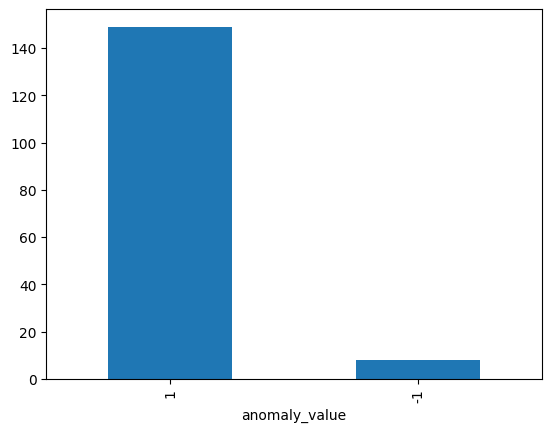

In [68]:
outliers_city = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value'] == -1]
outlier_index = list(outliers_city.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsWeeklyCity['anomaly_value'].value_counts())
NumberOfGuestsWeeklyCity['anomaly_value'].value_counts().plot(kind = 'bar')

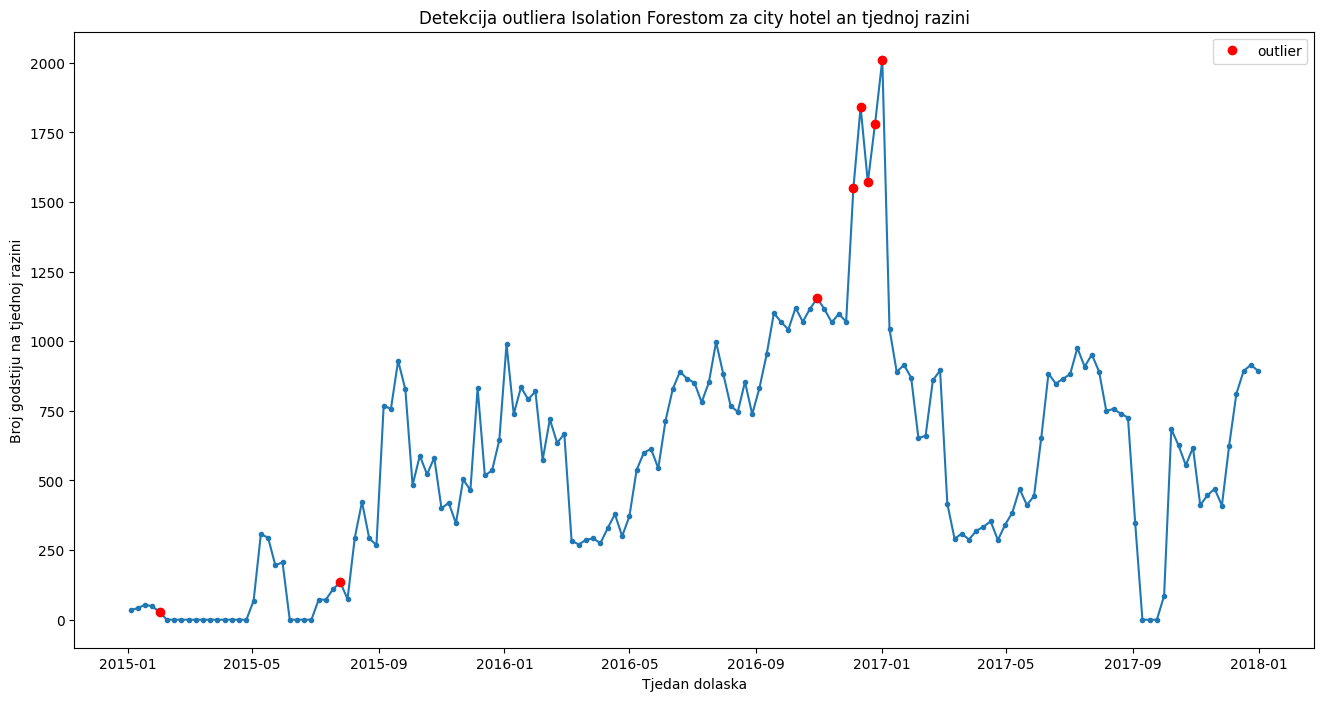

In [69]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker = '.')
plt.plot(outliers_city['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za city hotel an tjednoj razini')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj godstiju na tjednoj razini')
plt.legend()

In [136]:
outliers_fraction = float(0.05)

In [137]:
if_model_resort = IsolationForest(random_state = 0, 
                                  contamination = outliers_fraction ,
                                  bootstrap=False,
                                  verbose=True
                                 )

In [138]:
resort_data = NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)

In [141]:
scaler = StandardScaler()
resort_data_stand = scaler.fit_transform(resort_data )

In [142]:
if_model_resort.fit(resort_data_stand) #if_model_resort.fit(NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)) 

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [143]:
NumberOfGuestsWeeklyResort['score'] = if_model_resort.decision_function(resort_data_stand) #if_model_resort.decision_function(NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1))
NumberOfGuestsWeeklyResort['anomaly_value'] = if_model_resort.predict(resort_data_stand) #if_model_resort.predict(NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)) 
NumberOfGuestsWeeklyResort.head()

,ukupno_gostiju,score,anomaly_value
datum_dolaska,,,
2015-07-05,358.0,0.073555,1
2015-07-12,495.0,0.168078,1
2015-07-19,537.0,0.190954,1
2015-07-26,533.0,0.179562,1
2015-08-02,554.0,0.171272,1


anomaly_value
 1    108
-1      6
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

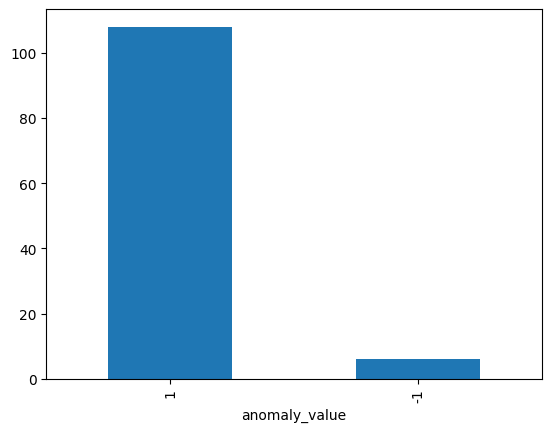

In [144]:
outliers_resort = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value'] == -1]
outlier_index_resort = list(outliers_resort.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsWeeklyResort['anomaly_value'].value_counts())
NumberOfGuestsWeeklyResort['anomaly_value'].value_counts().plot(kind = 'bar')

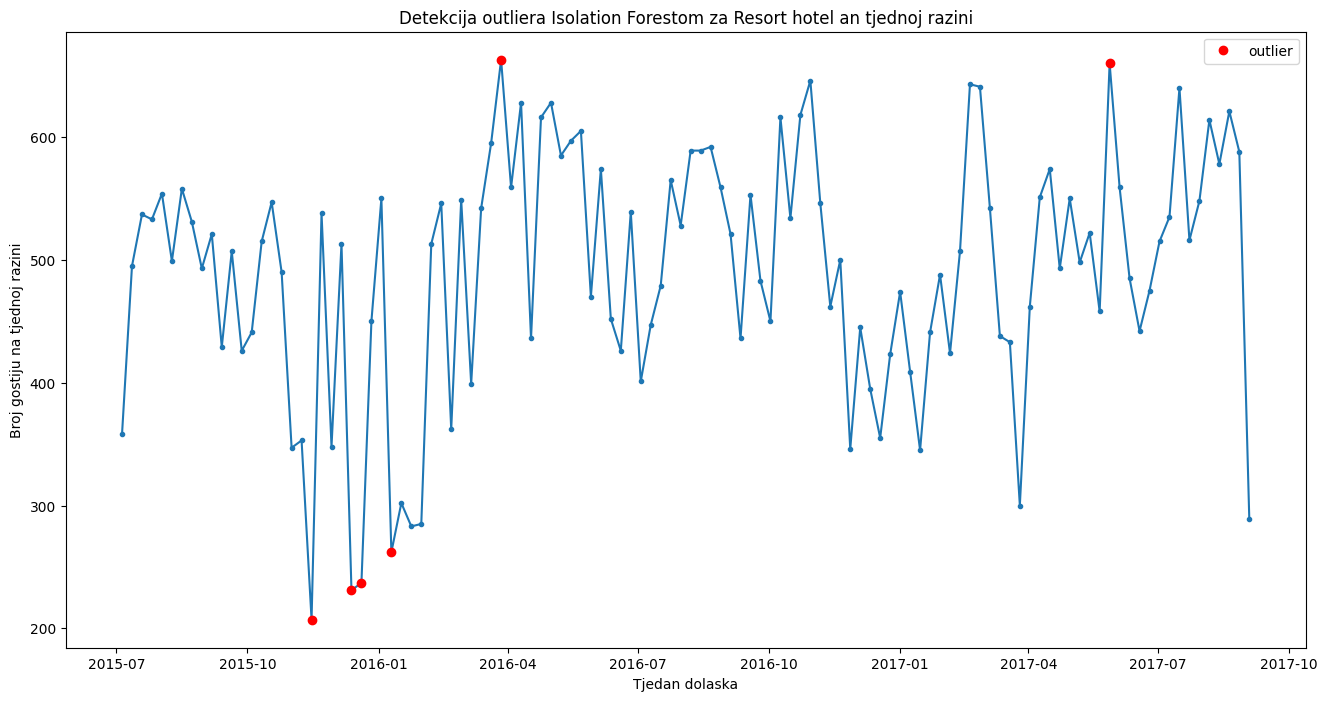

In [145]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker = '.')
plt.plot(outliers_resort['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za Resort hotel an tjednoj razini')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()

## One class SVM

In [162]:
from sklearn.svm import OneClassSVM

In [163]:
outliers_fraction = float(0.05)

In [170]:
osvm_city = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_city.fit(city_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [172]:
NumberOfGuestsWeeklyCity['anomaly_value_osvm'] = osvm_city.predict(city_data_stand)

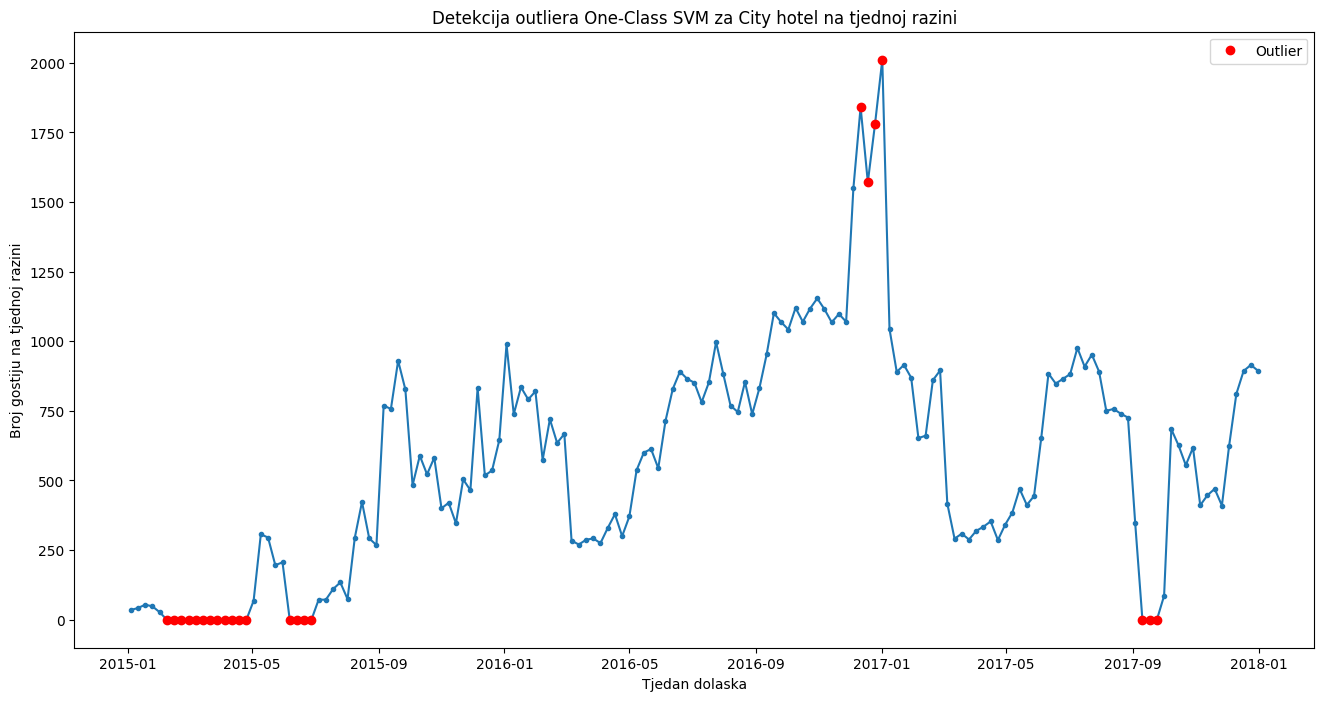

In [173]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za City hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [174]:
osvm_resort = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_resort.fit(resort_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [175]:
NumberOfGuestsWeeklyResort['anomaly_value_osvm'] = osvm_resort.predict(resort_data_stand)

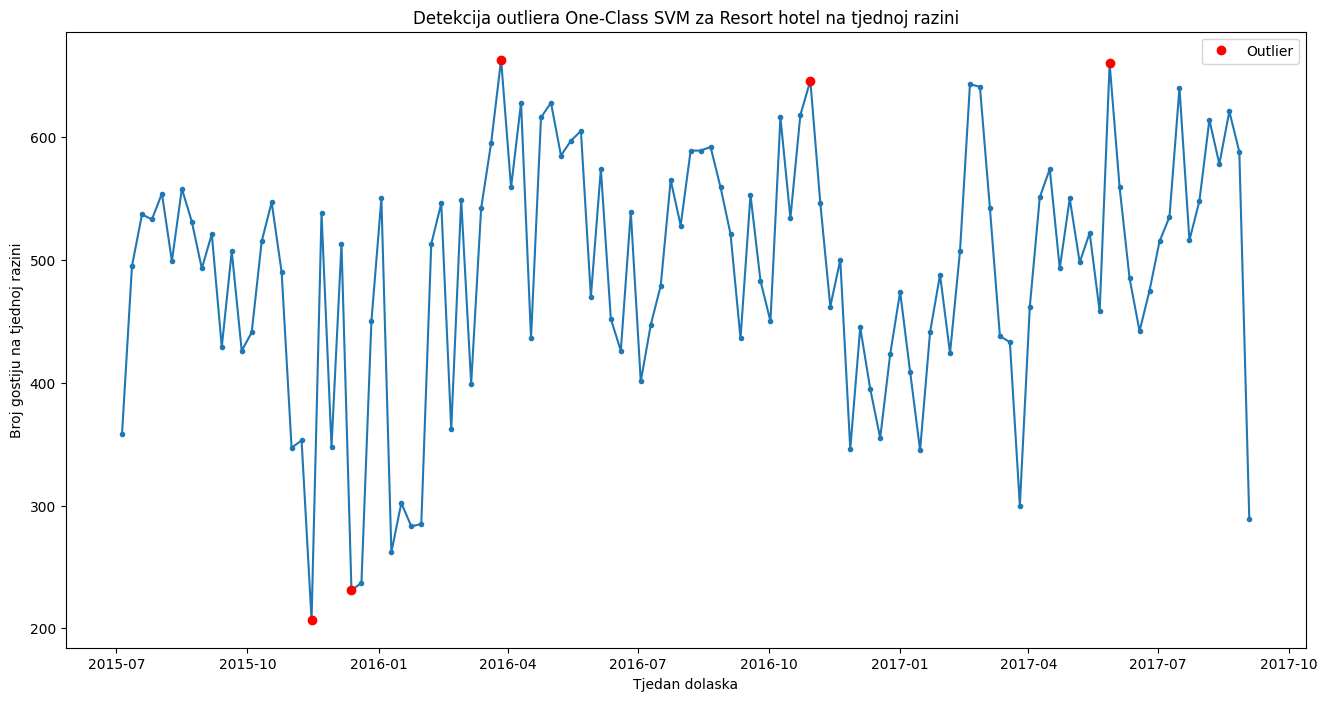

In [176]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


# TODO
- modelirati na mjesečnoj i dnevnoj razini   
- probati metodeAutoregressive Model (AR) ,Moving Average Model (MA) i K Means
      - moramo potvrditi pretpostavke : AR pretpostavlja da su podaci stacionarni
- proširiti na multivarijantnu analizu podataka 
      - agregacija podataka na razini dana,tjedna, mjeseca
      - provlačiti kroz neki pokretni prozor